In [1]:
import numpy as np
pi = np.pi
sqrt = np.sqrt
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats
import os, time

In [2]:
# make grid of tangent projection centers - every 10 deg

alphasdeg = np.linspace(-90,90,19) # elevation
alphas = np.multiply(pi/180,alphasdeg)
thetasdeg = np.linspace(-180,180,36,endpoint=False)# azimuth
thetas = np.multiply(pi/180,thetasdeg)

# make local points and handle reprojection to different locations 

def makegrid(fovdeg=10,res=10,f=1.0):
    xlim = f*np.tan(fovdeg/2 * pi/180)
    xx,yy = np.meshgrid(np.linspace(-xlim,xlim,res),np.linspace(-xlim,xlim,res))
    return xx,yy

xx,yy = makegrid(fovdeg=10,res=10)
xx = np.ndarray.flatten(xx)
yy = np.ndarray.flatten(yy)

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

In [3]:
# create flows for different velocities and geometries

# geometries
def nearness_local(geometry='sphere',x=xx,y=yy,r=1,alpha=0):
    if geometry == 'sphere':
        mu = 1/r*np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = np.abs(np.sin(y+alpha))/r * (y+alpha < 0)
    return mu

# flow from velocity
def getflow_local(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='sphere',r=1,f=1,
              x=xx,y=yy,theta=0,alpha=0):
    
    # rotate velocity to local patch
    V0 = [[Vx,Vy,Vz],[Wx,Wy,Wz]]
    R = makeR(theta,alpha)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Vx,Vy,Vz = V[0]
    Wx,Wy,Wz = V[1]
    
    # get nearness
    mu = nearness_local(geometry=geometry,x=x,y=y,r=r,alpha=alpha)
    
    # compute local flow
    flow_horiz = -Vx*f*mu + Vz*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    flow_vert = -Vy*f*mu + Vz*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    
    return flow_horiz,flow_vert  

([], [])

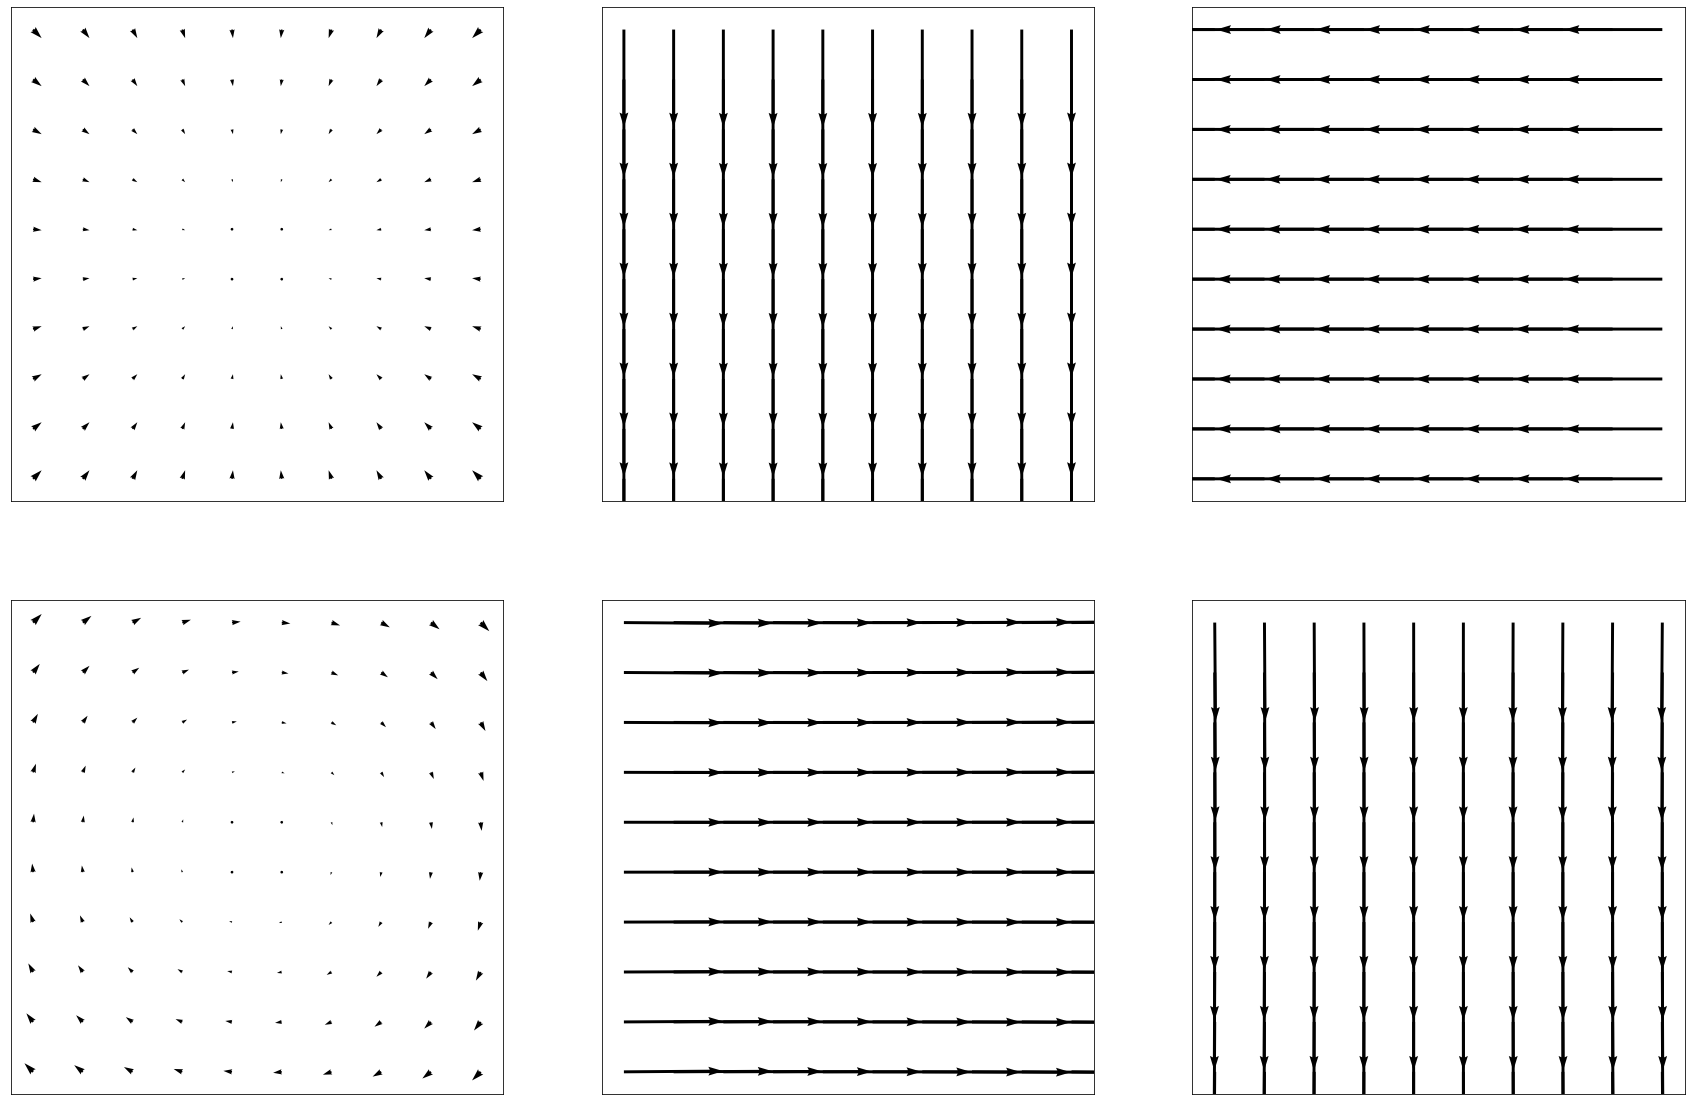

In [4]:
# show local templates

alpha=0
theta=np.pi/2
#theta=0
#alpha = -pi/2

s = 5 # make this bigger to make arrows smaller

halfres=False
if halfres:
    xgrid,ygrid= makegrid(fovdeg=60,res=5)
    xgrid = np.ndarray.flatten(xgrid)
    ygrid = np.ndarray.flatten(ygrid)
else:
    xgrid = xx
    ygrid = yy

plt.figure(figsize=(30,20))

plt.subplot(2,3,1)
template = getflow_local(Vx=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,2)
template = getflow_local(Vy=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,3)
template = getflow_local(Vz=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,4)
template = getflow_local(Wx=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,5)
template = getflow_local(Wy=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,6)
template = getflow_local(Wz=1,alpha=alpha,theta=theta,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0],template[1],scale=s)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])


#if alpha == 0 and theta == 0:
#    plt.savefig('./plots/local_templates_zero_zero.eps', format='eps')
#elif alpha == 0 and theta == -np.pi/2:
#    plt.savefig('./plots/local_templates_zero_ninety.eps', format='eps')

In [5]:
# predict self motion velocity from local flow patch
def getvel_local(flow,theta=0,alpha=0,x=xx,y=yy,geometry='sphere',DOFs=6,weights=np.ones_like(xx)):
    
    vxtemplate = np.ndarray.flatten(np.array(getflow_local(Vx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vytemplate = np.ndarray.flatten(np.array(getflow_local(Vy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vztemplate = np.ndarray.flatten(np.array(getflow_local(Vz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wxtemplate = np.ndarray.flatten(np.array(getflow_local(Wx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wytemplate = np.ndarray.flatten(np.array(getflow_local(Wy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wztemplate = np.ndarray.flatten(np.array(getflow_local(Wz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    # remove locations where flow is missing
    weights = np.copy(weights)
    weights[np.isnan(flow[0])] = 0
    weights[np.isnan(flow[1])] = 0
    flow[0][np.isnan(flow[0])] = 0
    flow[1][np.isnan(flow[1])] = 0
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    return np.squeeze(pred)


# angle difference for heading error`
def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

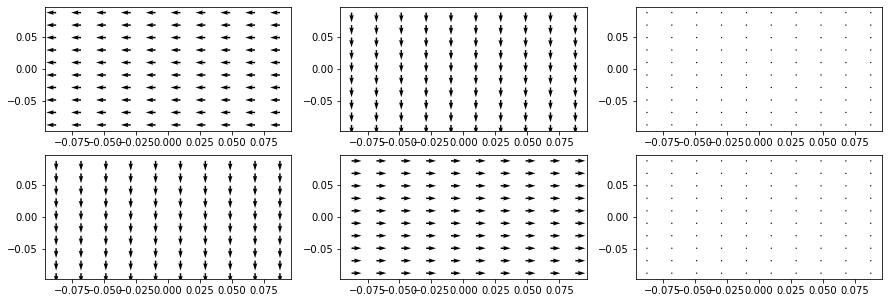

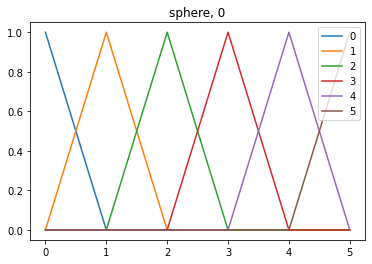

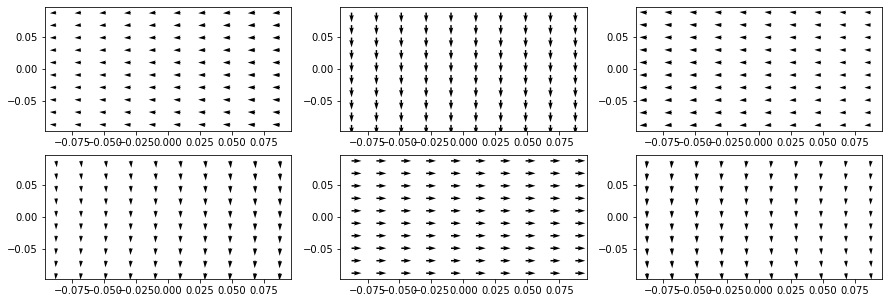

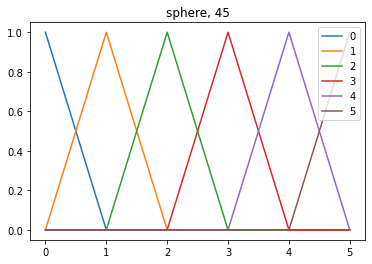

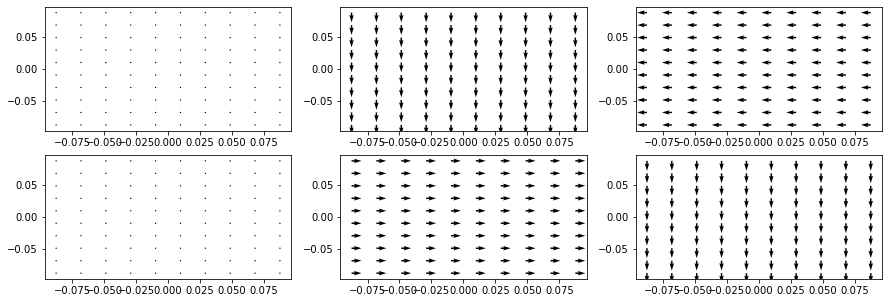

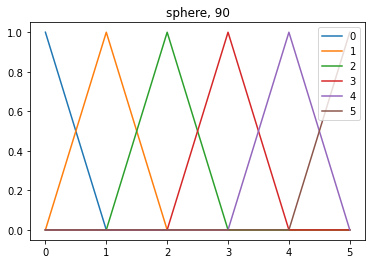

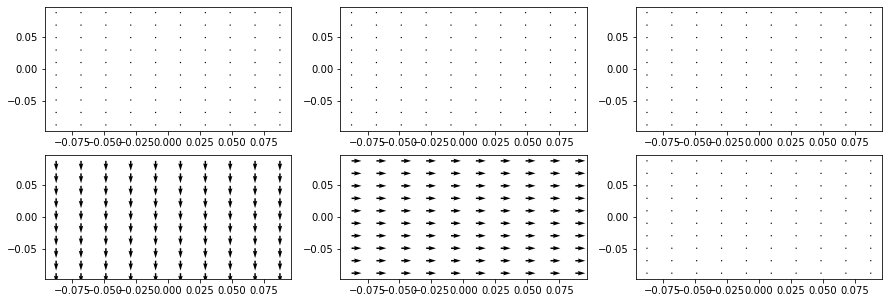

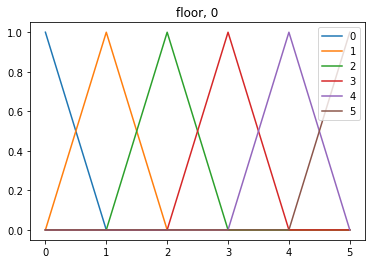

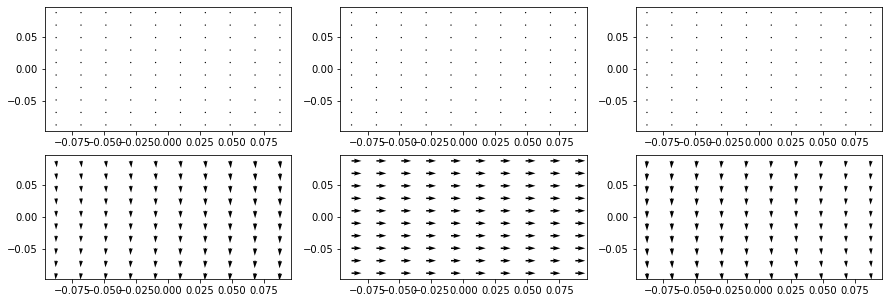

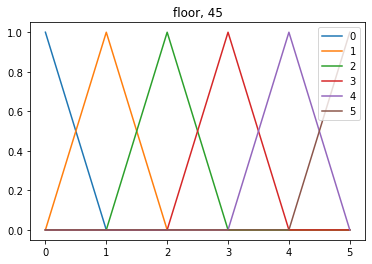

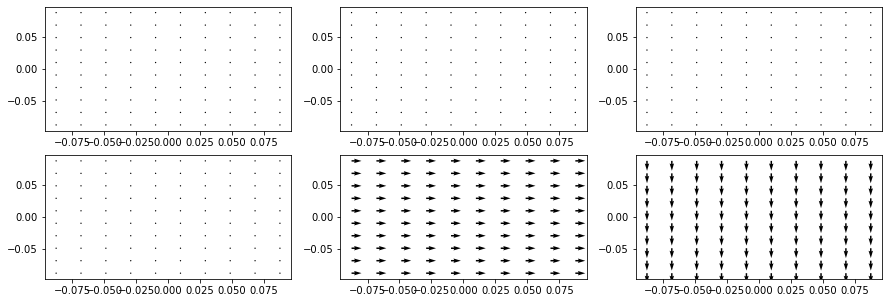

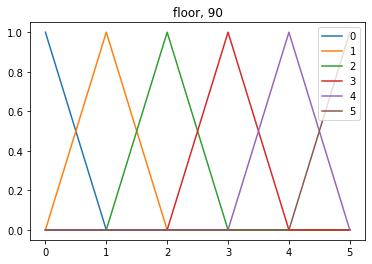

In [6]:
# plot flow templates and test flow prediction on noise-free unit vectors

for geometry in ['sphere','floor']:
    for theta in [0,pi/4,pi/2]:
        flows = [getflow_local(Vx=1,geometry=geometry,theta=theta), \
                getflow_local(Vy=1,geometry=geometry,theta=theta), \
                getflow_local(Vz=1,geometry=geometry,theta=theta), \
                getflow_local(Wx=1,geometry=geometry,theta=theta), \
                getflow_local(Wy=1,geometry=geometry,theta=theta), \
                getflow_local(Wz=1,geometry=geometry,theta=theta)]

        plt.figure(figsize=(15,5))
        for f,flow in enumerate(flows):
            plt.subplot(2,3,f+1)
            plt.quiver(xx,yy,flow[0],flow[1],scale=5*s)

        plt.figure()
        for f,flow in enumerate(flows):
            plt.plot(getvel_local(flow,geometry=geometry,theta=theta),label=f)
        plt.legend()
        plt.title(f'{geometry}, {theta*180/pi:.0f}')

In [7]:
# characterize local errors
def getlocalerrs(theta=0,alpha=0,
                 x=xx,y=yy,
                 trials=10000,
                 noiselevel=0.25,
                 spatvarnoise=False,
                 sparselevel=.667,
                 geometry='sphere',
                 DOFs=6,
                 plotit=False):

    errs = np.nan*np.ones([trials,DOFs+1])
    
    for i in range(trials): 
        
        # generate random behavior (uniform from -1 to 1)
        Vx,Vy,Vz,Wx,Wy,Wz = 2*np.random.rand(6) - 1
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        # create clean flow
        flow = getflow_local(geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,
                         Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        # add noise
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            noise = noise*((np.tile(-(y+alpha),[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise

        # make sparse
        sparsity = np.random.rand(h)
        flow[0][sparsity<sparselevel] = np.nan
        flow[1][sparsity<sparselevel] = np.nan
        
        # optionally, plot flows
        if plotit == True:
            plt.quiver(x,y,flow[0],flow[1],scale=10,color='r')
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
            plt.savefig(f'./plots/example_local_flow_{i}.eps', format='eps')

        # get prediction and errors
        preds = getvel_local(flow,geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,DOFs=DOFs)
        if DOFs == 3:
            gt =  [Vx,Vz,Wy]
        elif DOFs == 1:
            gt = [Vz]
        else:
            gt = [Vx,Vy,Vz,Wx,Wy,Wz]
        errs[i,:DOFs] = preds-gt
    
        # heading error
        if DOFs == 6:
            headinggt = np.arctan2(gt[0],gt[2])
            headingpred = np.arctan2(preds[0],preds[2])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr
        elif DOFs == 3:
            headinggt = np.arctan2(gt[0],gt[1])
            headingpred = np.arctan2(preds[0],preds[1])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr

    return errs

In [8]:
outdir = './local_simulation_files/'
ntrials = 10000

In [9]:
# Figure 1: 6DOF sphere, 66% sparsity and .25 noise

geometry = 'sphere'
behaviorDOFs = 6
sparselevel = .667
noiselevel = .25
spavarnoise = False

errs = np.nan*np.ones([len(alphas),len(thetas),ntrials,behaviorDOFs+1])
for a,alpha in enumerate(alphas):
    print(a,end=' ')
    for t,theta in enumerate(thetas):
        errs[a,t] = getlocalerrs(theta=theta,alpha=alpha,
                                    trials=ntrials,
                                    noiselevel=noiselevel,
                                    spatvarnoise=spavarnoise,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    DOFs=behaviorDOFs)
timestr = time.strftime("%Y%m%d-%H%M%S")
outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
np.savez(outfile,errs=errs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [10]:
# Figure 2 Behavior: 3DOF sphere, 66% sparsity and .25 noise

geometry = 'sphere'
behaviorDOFs = 3
sparselevel = .667
noiselevel = .25
spavarnoise = False

errs = np.nan*np.ones([len(alphas),len(thetas),ntrials,behaviorDOFs+1])
for a,alpha in enumerate(alphas):
    print(a,end=' ')
    for t,theta in enumerate(thetas):
        errs[a,t] = getlocalerrs(theta=theta,alpha=alpha,
                                    trials=ntrials,
                                    noiselevel=noiselevel,
                                    spatvarnoise=spavarnoise,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    DOFs=behaviorDOFs)
timestr = time.strftime("%Y%m%d-%H%M%S")
outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
np.savez(outfile,errs=errs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [11]:
# Figure 2 Behavior: 1DOF sphere, 66% sparsity and .25 noise

geometry = 'sphere'
behaviorDOFs = 1
sparselevel = .667
noiselevel = .25
spavarnoise = False

errs = np.nan*np.ones([len(alphas),len(thetas),ntrials,behaviorDOFs+1])
for a,alpha in enumerate(alphas):
    print(a,end=' ')
    for t,theta in enumerate(thetas):
        errs[a,t] = getlocalerrs(theta=theta,alpha=alpha,
                                trials=ntrials,
                                noiselevel=noiselevel,
                                spatvarnoise=spavarnoise,
                                sparselevel=sparselevel,
                                geometry=geometry,
                                DOFs=behaviorDOFs)
timestr = time.strftime("%Y%m%d-%H%M%S")
outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
np.savez(outfile,errs=errs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [9]:
# Figure 2 Geometry: 3DOF floor, 66% sparsity and .25 noise

geometry = 'floor'
behaviorDOFs = 3
sparselevel = .667
noiselevel = .25
spavarnoise = False

errs = np.nan*np.ones([len(alphas),len(thetas),ntrials,behaviorDOFs+1])
for a,alpha in enumerate(alphas):
    print(a,end=' ')
    for t,theta in enumerate(thetas):
        errs[a,t] = getlocalerrs(theta=theta,alpha=alpha,
                                trials=ntrials,
                                noiselevel=noiselevel,
                                spatvarnoise=spavarnoise,
                                sparselevel=sparselevel,
                                geometry=geometry,
                                DOFs=behaviorDOFs)
timestr = time.strftime("%Y%m%d-%H%M%S")
outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
np.savez(outfile,errs=errs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [13]:
# Figure 2 Noise: 3DOF sphere, 66% sparsity and spatially varying noise

geometry = 'sphere'
behaviorDOFs = 3
noiselevel = .25
sparselevel = .667
spavarnoise = True

errs = np.nan*np.ones([len(alphas),len(thetas),ntrials,behaviorDOFs+1])
for a,alpha in enumerate(alphas):
    print(a,end=' ')
    for t,theta in enumerate(thetas):
        errs[a,t] = getlocalerrs(theta=theta,alpha=alpha,
                                trials=ntrials,
                                noiselevel=noiselevel,
                                spatvarnoise=spavarnoise,
                                sparselevel=sparselevel,
                                geometry=geometry,
                                DOFs=behaviorDOFs)

timestr = time.strftime("%Y%m%d-%H%M%S")
outfile = f'{outdir}local_{sparselevel*100:.0f}pctsparse_{ntrials}trials_{noiselevel}noise_spatvarnoise_{geometry}_{behaviorDOFs}DOFs_{timestr}'
np.savez(outfile,errs=errs)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 